In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split



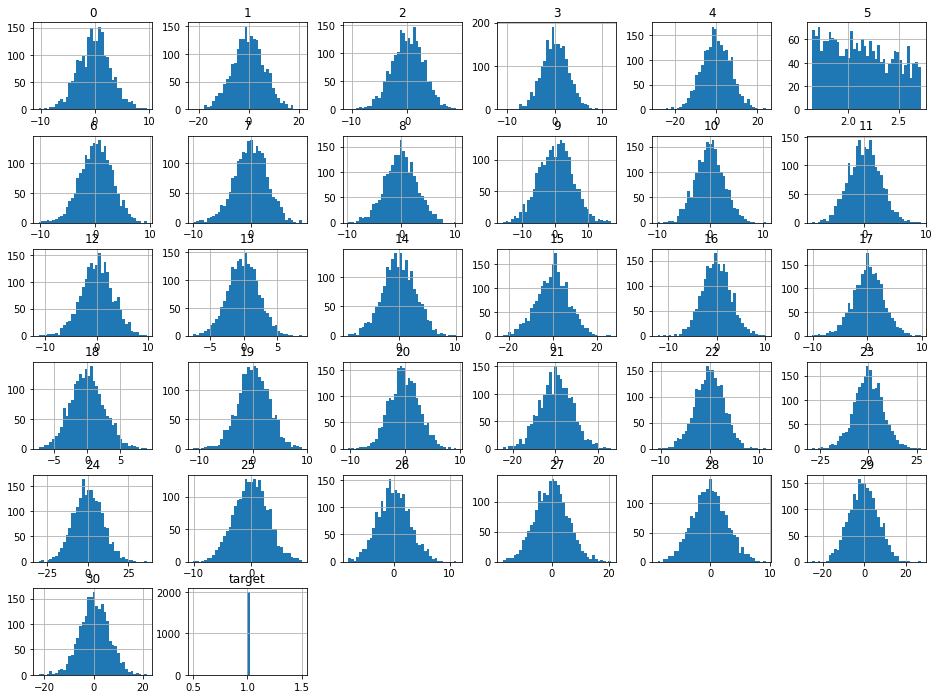

In [2]:
df = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

# del df['5'] 

x_train, x_valid, y_train, y_valid = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values, 
                                                      stratify=df.iloc[:, -1].values, random_state=42)
df.iloc[df.target.values == 1, :].hist(figsize=(16, 12), bins=40)
plt.show()


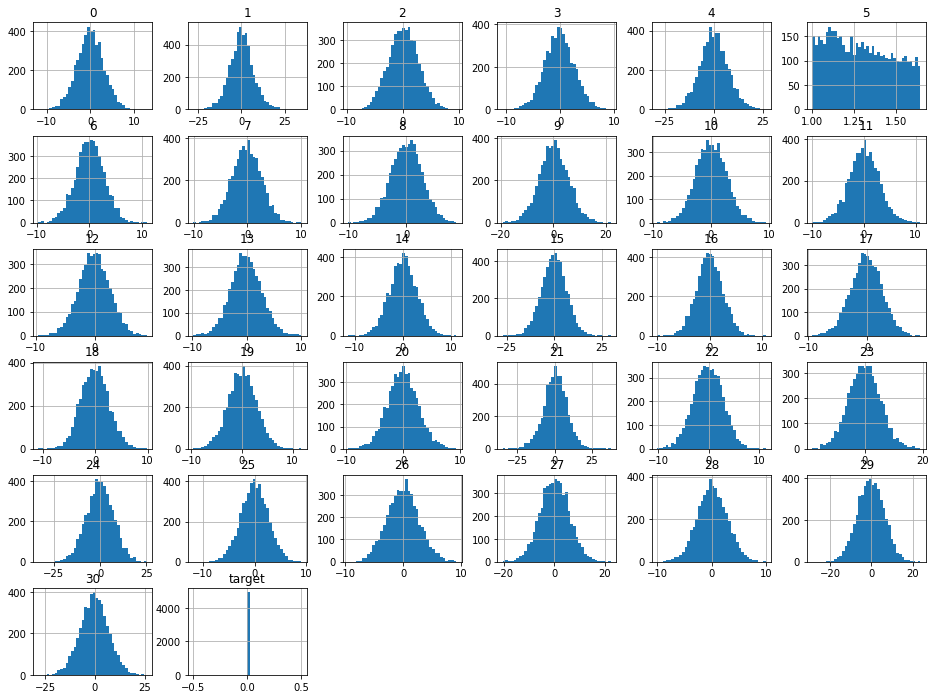

In [3]:
df.iloc[df.target.values == 0, :].hist(figsize=(16, 12), bins=40)
plt.show()

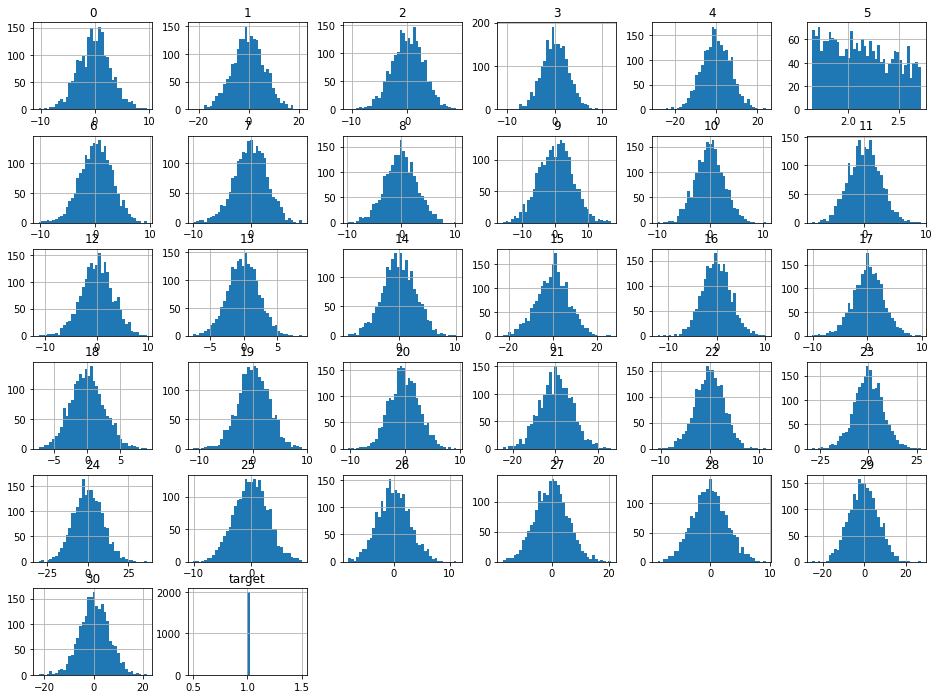

In [4]:
df.iloc[df.target.values == 1, :].hist(figsize=(16, 12), bins=40)
plt.show()

In [5]:
x_train.shape[1]

31

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



def test_features(x_train, x_valid, y_train, y_valid, verbose=True):
    results_F1 = {'train': [], 'valid': []}
    results_auc = {'train': [], 'valid': []}
    model = Pipeline([
        ('SS', StandardScaler()),
        ('SVC', SVC(kernel='rbf', C=1, probability=True))
    ])
    for n_feat in tqdm(range(1, x_train.shape[1])):
        model.fit(x_train[:, :n_feat], y_train)
        pred_train = model.predict(x_train[:, :n_feat])
        pred_valid = model.predict(x_valid[:, :n_feat])
        results_F1['train'].append(f1_score(y_train, pred_train))
        results_F1['valid'].append(f1_score(y_valid, pred_valid))
        if verbose:
            print(f'n_feat: {n_feat}')
            print(f'train: {f1_score(y_train, pred_train)}')
            print(f'valid: {f1_score(y_valid, pred_valid)}')
            print(' ')
    return results_F1

  0%|          | 0/30 [00:00<?, ?it/s]

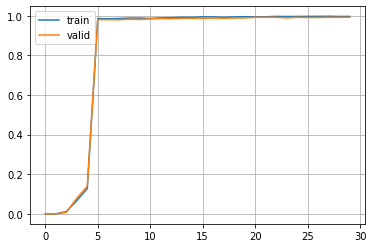

In [7]:
results_F1 = test_features(x_train, x_valid, y_train, y_valid, verbose=False)
plt.grid()
plt.plot(results_F1['train'], label='train')
plt.plot(results_F1['valid'], label='valid')
plt.legend()
plt.show()


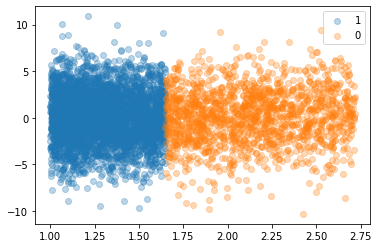

In [8]:
plt.scatter(x_train[y_train==0, 5], x_train[y_train==0, 6], label = '1', alpha=0.3)
plt.scatter(x_train[y_train==1, 5], x_train[y_train==1, 6], label = '0', alpha=0.3)
plt.legend()
plt.show()


  0%|          | 0/29 [00:00<?, ?it/s]

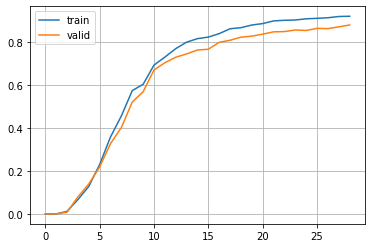

In [9]:
df = pd.read_csv('../input/train.csv')
del df['5']
x_train, x_valid, y_train, y_valid = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values, 
                                                      stratify=df.iloc[:, -1].values, random_state=42)
results_F1 = test_features(x_train, x_valid, y_train, y_valid, verbose=False)
plt.grid()
plt.plot(results_F1['train'], label='train')
plt.plot(results_F1['valid'], label='valid')
plt.legend()
plt.show()

In [10]:
df.corr().style.background_gradient()

,0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,target
0,1.000000,-0.150504,-0.031684,-0.119729,-0.429410,0.163108,0.060768,0.013848,-0.104773,0.237665,0.149895,-0.091785,0.016672,0.016753,-0.477741,-0.043302,-0.015497,-0.152718,0.190584,-0.096562,0.178463,0.164363,-0.125456,-0.337168,-0.061916,-0.153491,-0.173254,0.052345,-0.144753,-0.018940,-0.009456
1,-0.150504,1.000000,0.249603,0.041488,-0.039483,-0.195778,-0.191716,0.127857,-0.199508,0.139047,-0.166060,0.237614,0.112427,-0.468066,-0.122787,-0.137192,-0.213601,-0.007135,0.053529,-0.260690,-0.121946,0.259262,-0.006155,0.190114,-0.307530,-0.137446,0.392216,0.284322,-0.005216,-0.143356,-0.016829
2,-0.031684,0.249603,1.000000,0.013315,0.263741,0.117693,0.024842,0.262330,0.401124,-0.010746,0.129228,0.208119,-0.033604,0.093598,-0.245421,0.004657,0.009416,0.054872,0.022424,0.081488,0.205685,0.020286,-0.248789,-0.019600,-0.019678,0.114791,0.122596,-0.046960,0.226250,-0.265365,-0.013655
3,-0.119729,0.041488,0.013315,1.000000,-0.045332,-0.109396,0.100969,0.069063,0.242621,-0.075826,-0.156553,-0.121246,0.027686,0.049728,0.220741,0.085964,0.086544,0.108206,0.098086,0.101832,-0.113575,-0.116189,-0.373033,0.080756,-0.036977,-0.031316,-0.190707,-0.002422,0.313397,0.228647,0.030377
4,-0.429410,-0.039483,0.263741,-0.045332,1.000000,0.205774,-0.104539,-0.077366,0.363558,0.149486,0.315509,0.347398,-0.082398,-0.044043,0.165506,-0.157620,-0.110253,-0.084899,-0.246415,0.266201,0.093359,-0.156819,0.144513,-0.147485,0.351241,0.550878,-0.319312,0.023675,-0.178696,-0.092773,0.004322
6,0.163108,-0.195778,0.117693,-0.109396,0.205774,1.000000,0.036156,0.112151,0.173130,0.057142,0.109011,0.069086,0.082227,0.152229,-0.052662,-0.157322,-0.086236,-0.155509,0.107351,-0.026385,0.304553,-0.089440,-0.113735,-0.239311,0.106869,0.170283,-0.204228,0.137407,-0.358567,0.226725,0.011769
7,0.060768,-0.191716,0.024842,0.100969,-0.104539,0.036156,1.000000,0.019800,-0.029455,0.027291,-0.018671,0.054347,0.235482,0.114687,-0.293454,-0.065363,0.229125,-0.016963,0.036256,-0.118520,-0.154843,-0.092679,-0.253981,-0.334525,0.067639,0.026509,-0.317490,-0.059970,0.192219,0.486808,0.016147
8,0.013848,0.127857,0.262330,0.069063,-0.077366,0.112151,0.019800,1.000000,0.182448,0.067739,0.007979,-0.025197,0.023483,0.130461,-0.332310,-0.006108,-0.083296,0.032218,0.186428,0.144517,0.387476,-0.114682,-0.307185,0.159375,0.085408,-0.033855,0.131899,-0.109823,-0.115349,-0.171463,-0.013129
9,-0.104773,-0.199508,0.401124,0.242621,0.363558,0.173130,-0.029455,0.182448,1.000000,-0.104576,0.239475,0.236683,-0.185186,0.285566,-0.032965,0.091770,-0.162260,-0.068708,0.410856,0.328781,0.417740,-0.355922,-0.065667,-0.070035,0.082072,0.296589,-0.210119,-0.224147,-0.140438,-0.172007,0.010100
10,0.237665,0.139047,-0.010746,-0.075826,0.149486,0.057142,0.027291,0.067739,-0.104576,1.000000,0.055411,0.034689,0.030918,-0.139033,-0.417137,-0.166025,-0.125920,-0.019741,0.165864,0.117403,0.417430,0.056199,0.037534,-0.275762,-0.043407,0.206164,-0.266195,-0.033939,-0.075940,0.058074,-0.017327


[12.90873387  9.69141443  9.44677949  8.33858477  6.58719416  6.3241478
  5.79495912  4.71936222  4.38723832  4.12088777  3.58662159  3.37980168
  3.21276167  2.98053072  2.61110965  2.35324522  2.00334199  1.87355252
  1.67311933  1.58570882  0.33870425  0.32402577  0.29514806  0.2817616
  0.24890909  0.23931503  0.20978603  0.19947627  0.14857273  0.13520599]


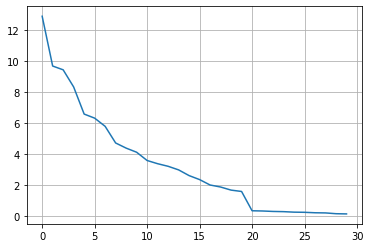

In [11]:
scaler = StandardScaler()
x_st = scaler.fit_transform(df.iloc[:, :-1].values)
u, s, v = np.linalg.svd(x_st.T @ x_st)
print(s/s.sum() * 100)
plt.grid()
plt.plot(s/s.sum()*100)
plt.show()

/Users/a19028558/Desktop/MADE/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


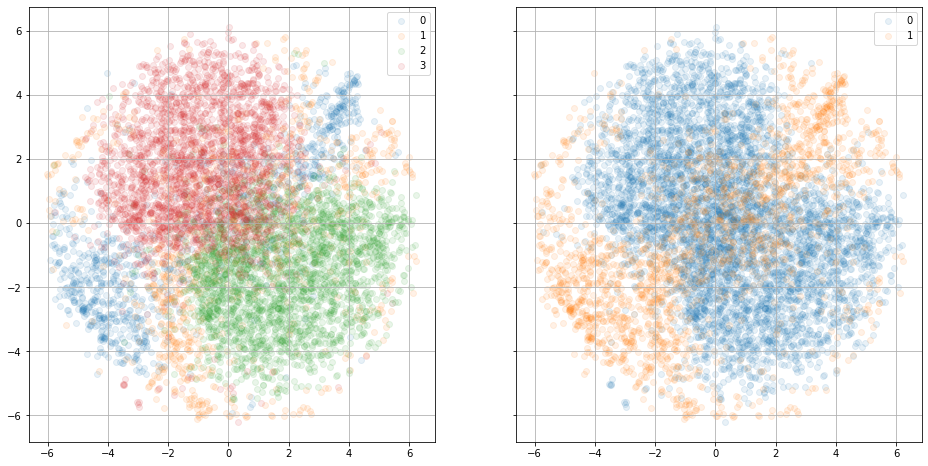

In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())  # список цветов


tsne = Pipeline([
    ('SS', StandardScaler()), # 50, 70, 105, 115
    ('TSNE', TSNE(n_components=2, perplexity=115, random_state=42, learning_rate = 100,
                  metric='mahalanobis', init='pca', square_distances=True, 
                 ))
])

cluster_model = Pipeline([
    ('SS', StandardScaler()),
    ('GM', GaussianMixture(n_components=4, random_state=42, n_init=10))
])

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

labels = cluster_model.fit_predict(X)

x_tsne = tsne.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (16, 8), sharey=True)
for i in np.unique(labels):
    ax1.scatter(x_tsne[i == labels, 0], x_tsne[i == labels, 1], cmap=colors_list[i], alpha=0.1, label=i)
for i in np.unique(y_train):
    ax2.scatter(x_tsne[i == y, 0], x_tsne[i == y, 1], cmap=colors_list[i], alpha=0.1, label=i)
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

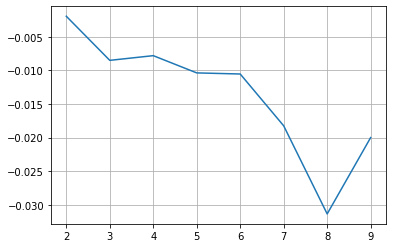

In [13]:
from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans

def find_n_clusters(X, n=10):
    scores = []
    for i in tqdm(range(2, n)):
        cluster_model = Pipeline([
            ('SS', StandardScaler()),
            ('GM', GaussianMixture(n_components=i, random_state=42, n_init=10))
        ])
        labels = cluster_model.fit_predict(X)
        scores.append(silhouette_score(X, labels, metric='mahalanobis', random_state=42))
    return scores

scores = find_n_clusters(X, 10)
plt.plot(range(2, len(scores)+2), scores)
plt.grid()

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import GaussianMixture
svc = Pipeline([
    ('SS', StandardScaler()),
    ('SVC', SVC(kernel='rbf', C=3, probability=True, random_state=42, class_weight='balanced'))
])

cluster_model = Pipeline([
    ('SS', StandardScaler()),
    ('GM', GaussianMixture(n_components=4, random_state=42, n_init=10))
])


cluster_model.fit(df.iloc[:, :-1])
proba = cluster_model.predict_proba(df.iloc[:, :-1])

X = np.hstack([df.iloc[:, :-1], proba])
y = df.iloc[:, -1]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pbar = tqdm(iter(skf.split(X, y)), leave = True, total=5)    

noises = []
for train_index, valid_index in pbar:
    svc.fit(X[train_index], y[train_index])
    pred_proba = svc.predict_proba(X[valid_index])[:, 0]
    pred = svc.predict(X[valid_index])
    mask1 = pred != y[valid_index]
    mask2 = (pred_proba > 0.7) + (pred_proba < 0.3)
    mask = mask1 & mask2
    noises += valid_index[mask].tolist()
df.drop(index=noises, axis=0, inplace=True)
df.reset_index()

  0%|          | 0/5 [00:00<?, ?it/s]

,index,0,1,2,3,4,6,7,8,9,...,22,23,24,25,26,27,28,29,30,target
0,0,-6.130724,7.429628,3.651437,-1.950971,-3.384415,-3.077774,-2.619091,5.128201,1.228476,...,0.392978,4.920467,16.610460,-2.430804,-1.405573,18.610209,-4.140715,6.027816,-20.288145,0
1,1,5.161836,-6.514011,-7.474612,-4.544336,-13.081404,-1.094672,-1.253545,-2.955342,-10.958200,...,-4.840233,-0.514308,4.613289,2.391302,-4.795664,4.208278,-2.017168,-8.510424,10.806639,0
2,2,-2.971550,-21.508184,-1.125457,1.524129,3.027444,1.551050,1.512075,-1.955564,3.683893,...,-0.385303,2.647917,-2.200556,1.058671,1.076312,-7.802389,-7.553953,0.636639,14.274950,0
3,3,6.724419,0.566489,0.509764,-4.524162,10.367236,0.741790,-2.077787,-2.912744,-4.040637,...,4.731346,15.378418,-14.031666,2.659410,5.123620,-8.500321,3.417960,-14.798490,-6.132800,1
4,4,-2.213659,-4.678213,-0.135845,2.375933,0.916649,-0.353265,-0.220609,-3.416823,-5.964181,...,1.598330,-4.996614,4.504269,1.918961,-2.076223,0.154039,-2.016779,10.803205,5.942927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6867,6957,-0.896727,-1.081807,-0.992381,0.147425,5.941532,2.117062,1.254686,0.035905,1.025841,...,2.404494,5.175765,5.075319,-2.230586,1.850830,-4.405087,3.328801,-1.303900,-4.153117,1
6868,6958,1.554111,2.018845,-2.550991,-2.049014,0.931923,2.260598,0.907393,0.559868,-0.366525,...,-2.078071,2.774934,-5.819371,-1.397282,0.629832,-1.098601,-7.498520,-7.752161,12.691050,0
6869,6960,-2.348591,-8.263995,-0.318484,1.851011,-4.880470,-4.348202,2.937274,-3.067852,-0.173702,...,0.819033,0.794195,9.353774,-1.841798,-1.116251,6.708149,-1.841971,5.747190,-7.608288,0
6870,6961,5.481595,4.899412,-0.421851,4.639328,-20.671090,-3.838050,0.622003,1.548813,-8.847505,...,1.697137,-8.315975,6.149865,1.437154,-7.284716,4.566744,-0.908937,11.555781,2.889093,0


In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values, 
                                                      stratify=df.iloc[:, -1].values, random_state=42)

cl = Pipeline([
    ('SS', StandardScaler()),
    ('GM', GaussianMixture(n_components=4, random_state=42, n_init=10))
])



cl.fit(x_train)
train_proba = cl.predict_proba(x_train)
valid_proba = cl.predict_proba(x_valid)
x_train_ = np.hstack([x_train, train_proba])
x_valid_ = np.hstack([x_valid, valid_proba])




model = Pipeline([
    ('SS', StandardScaler()),
    ('SVC', SVC(kernel='rbf', C=1, degree=3, probability=True, random_state=42, class_weight='balanced'))
])

model.fit(x_train_, y_train)
pred_train = model.predict(x_train_)
pred_valid = model.predict(x_valid_)
print(f'train: {f1_score(y_train, pred_train)}')
print(f'valid: {f1_score(y_valid, pred_valid)}')

train: 0.9952283571915473
valid: 0.9979508196721312


In [21]:
from sklearn.model_selection import StratifiedKFold



def cross_val_score(cluster_model, feature_model, cls_model, X, y, n_splits=10): 
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    sub_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    f1_train = []
    f1_valid = []
    pbar = tqdm(iter(skf.split(X, y)), leave = True, total=n_splits) 
    for train_index, valid_index in pbar:
        cluster_model.fit(X[train_index])
        pred_cluster_proba_train = cluster_model.predict_proba(X[train_index])
        pred_cluster_proba_valid = cluster_model.predict_proba(X[valid_index])
        
        model_features = []
        
        sub_pbar = tqdm(iter(sub_skf.split(X[train_index], y[train_index])), leave = True, total=n_splits)
        for sub_train, sub_valid in sub_pbar:
            feature_model.fit(X[train_index][sub_train], y[train_index][sub_train])
            model_features.append(feature_model.predict_proba(X[train_index][sub_valid]))
        feature_model.fit(X[train_index], y[train_index])
        pred_feature_proba_train = np.vstack(model_features)
        pred_feature_proba_valid = feature_model.predict_proba(X[valid_index])
        
        x_train = np.hstack([pred_feature_proba_train, pred_cluster_proba_train, X[train_index]])
        x_valid = np.hstack([pred_feature_proba_valid, pred_cluster_proba_valid, X[valid_index]])
        model.fit(x_train, y[train_index])
        pred_train = model.predict(x_train)
        pred_valid = model.predict(x_valid)
        f1_train.append(f1_score(pred_train, y[train_index]))
        f1_valid.append(f1_score(pred_valid, y[valid_index]))
        
    return f1_train, f1_valid

In [30]:
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture



cluster_model = Pipeline([
    ('SS', StandardScaler()),
#     ('pca', PCA(n_components=0.99, random_state=42)),  # хуже работает
#     ('GM', BayesianGaussianMixture(n_components=5, random_state=42, n_init=10))
    ('GM', GaussianMixture(n_components=4, random_state=42, n_init=10))
])
 
svc = Pipeline([
    ('SS', StandardScaler()),
#     ('pca', PCA(n_components=20, random_state=42)),  # хуже работает
    ('SVC', SVC(kernel='rbf', C=3, probability=True, random_state=42, class_weight='balanced'))
])


cat = CatBoostClassifier(
    n_estimators=400,
    depth=4,
    learning_rate=0.2,
    rsm=0.5,
    random_state=42, 
    auto_class_weights='Balanced',
#     auto_class_weights='SqrtBalanced',
    l2_leaf_reg = 10,
    verbose=False,
    eval_metric='F1'
)


f1_train, f1_valid = cross_val_score(
    cluster_model, cat, svc, df.iloc[:, :-1].values, df.iloc[:, -1].values, n_splits=10)



print('train: ', sum(f1_train) / len(f1_train))
print('valid: ', sum(f1_valid) / len(f1_valid))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

train:  0.9978993072098508
valid:  0.9951366799084163


In [29]:
# %%capture
x_train, x_valid, y_train, y_valid = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values, 
                                                      stratify=df.iloc[:, -1].values, random_state=42)

cl = Pipeline([
    ('SS', StandardScaler()),
    ('GM', GaussianMixture(n_components=4, random_state=42, n_init=10))
])



cl.fit(x_train)
train_proba = cl.predict_proba(x_train)
valid_proba = cl.predict_proba(x_valid)
x_train_ = np.hstack([x_train, train_proba])
x_valid_ = np.hstack([x_valid, valid_proba])

train_pool = Pool(x_train_, y_train)
valid_pool = Pool(x_valid_, y_valid)
cat = CatBoostClassifier(
    n_estimators=400,
    depth=4,
    learning_rate=0.1,
    rsm=0.5,
    
    random_state=42, 
    auto_class_weights='Balanced',
    l2_leaf_reg = 100,
    verbose=True,
    eval_metric='F1'
)

cat.fit(train_pool, eval_set=valid_pool)
pred_train = cat.predict(train_pool)
pred_valid = cat.predict(valid_pool)
train_proba = cat.predict_proba(train_pool)
valid_prona = cat.predict_proba(valid_pool)

print(f'train: {f1_score(y_train, pred_train)}')
print(f'valid: {f1_score(y_valid, pred_valid)}')


train: 0.9928692699490663
valid: 0.9979550102249489


In [31]:
def predict(cluster_model, feature_model, cls_model, X, y, X_test, n_splits=10): 
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)        
    pbar = tqdm(iter(skf.split(X, y)), leave = True, total=n_splits)    
    x_train = []
    y_train = []
    pred_feature_proba_train = []
    for train_index, valid_index in pbar:
        x_train.append(X[valid_index])
        y_train.append(y[valid_index].reshape(-1, 1))
        feature_model.fit(X[train_index], y[train_index])
        pred_feature_proba_train.append(feature_model.predict_proba(X[valid_index]))
    x_train = np.vstack(x_train)
    pred_feature_proba_train = np.vstack(pred_feature_proba_train)
    y_train = np.vstack(y_train).reshape(-1)
    cluster_model.fit(x_train)
    feature_model.fit(x_train, y_train)
    pred_cluster_proba_train = cluster_model.predict_proba(x_train)
    x_train = np.hstack([pred_feature_proba_train, pred_cluster_proba_train, x_train])
    pred_feature_proba_test = feature_model.predict_proba(X_test)
    pred_cluster_proba_test = cluster_model.predict_proba(X_test)
    x_test = np.hstack([pred_feature_proba_test, pred_cluster_proba_test, X_test])
    cls_model.fit(x_train, y_train)
    pred_test = cls_model.predict(x_test)  
    return pred_test

In [32]:
df_test = pd.read_csv('../input/test.csv')
del df_test['5']


cat = CatBoostClassifier(
    n_estimators=400,
    depth=4,
    learning_rate=0.1,
    rsm=0.5,
    
    random_state=42, 
    auto_class_weights='Balanced',
    l2_leaf_reg = 100,
    verbose=False,
    eval_metric='F1'
)

cat1 = CatBoostClassifier(
    n_estimators=8,
    depth=4,
    learning_rate=0.1,
    rsm=0.5,
    
    random_state=42, 
    auto_class_weights='Balanced',
    l2_leaf_reg = 100,
    verbose=False,
    eval_metric='F1'
)

pred_test = predict(cluster_model, cat, cat1, df.iloc[:, :-1].values, 
                    df.iloc[:, -1].values, df_test.values, n_splits=10)

submit = pd.read_csv('../input/sample_submission_copy.csv')
submit.target = pred_test

submit.to_csv('f7.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '../input/sample_submission_copy.csv'